In [1]:
# Time Series forecasting of the price of Natural Gas
# Forecasting models ARIMA and SARIMA

# Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, 
# is an extension of ARIMA that explicitly supports univariate time series data 
# with a seasonal component.
# It adds three new hyperparameters to specify the autoregression (AR), 
# differencing (I) and moving average (MA) for the seasonal component of the series,
# as well as an additional parameter for the period of the seasonality.

In [2]:
#Import of Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

In [3]:
# Data import
price_data_daily = pd.read_excel('c:/Python/data_sets/nat_gas_daily_csv.xlsx', parse_dates=True, index_col=0)
price_data_daily = price_data_daily.dropna()

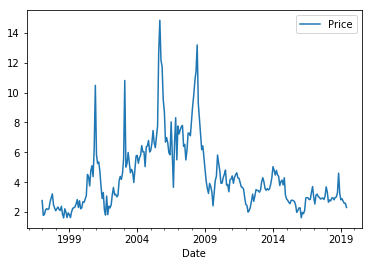

In [4]:
#Resampling daily data to monthly data
#price_data = price_data_daily.resample('W').last()
#Above command uses the mean price value of each month. Alternatively, we can use the month-end value of the 
#price series with following command:
price_data = price_data_daily.resample('M').last()

frequency = 12 #12 for monthly data; 52 for weekly data

#Shortening history to post 2008/2009 financial crisis period
#price_data = price_data.tail(110)
price_data.plot()
price_data = price_data.dropna()

In [5]:
price_data.head()

,Price
Date,
1997-01-31,2.77
1997-02-28,1.78
1997-03-31,1.84
1997-04-30,2.16
1997-05-31,2.23


In [6]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 270 entries, 1997-01-31 to 2019-06-30
Freq: M
Data columns (total 1 columns):
Price    270 non-null float64
dtypes: float64(1)
memory usage: 4.2 KB


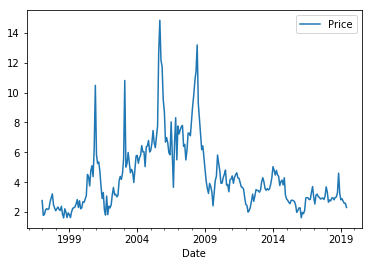

In [7]:
price_data.plot()
price_data = price_data.dropna()

<Figure size 432x288 with 0 Axes>

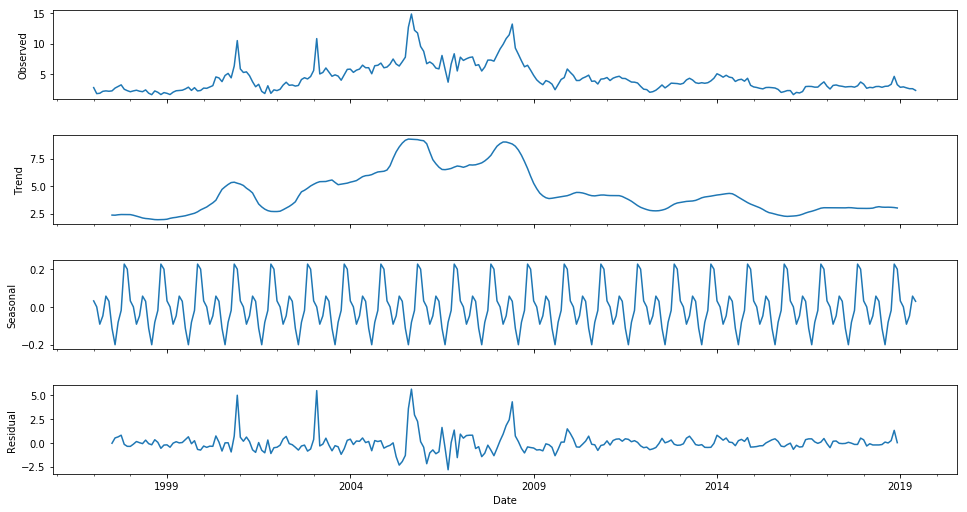

In [8]:
decomposition = seasonal_decompose(price_data.Price, model='additive', freq=frequency)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

#Saving each component of the seasonal decomposition:
trend = decomposition.trend
seasonal = decomposition.seasonal 
#residual = decomposition.residual 'Doesn't work

In [9]:
#Function calling Statsmodels

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(frequency).mean()
    rolstd = timeseries.rolling(frequency).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(8, 4))
    orig = plt.plot(timeseries, color='green',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='blue', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

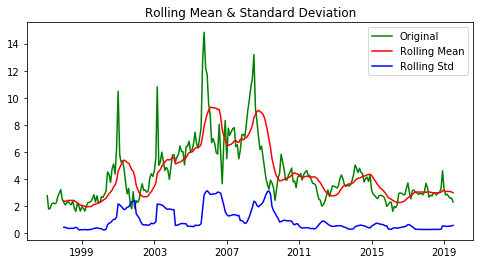

Results of Dickey-Fuller Test:
Test Statistic                  -2.910074
p-value                          0.044189
#Lags Used                       2.000000
Number of Observations Used    267.000000
Critical Value (1%)             -3.455081
Critical Value (5%)             -2.872427
Critical Value (10%)            -2.572571
dtype: float64


In [10]:
test_stationarity(price_data.Price)

In [11]:
#The Dickey-Fuller test statistic higher than the 1% critical value. The time series does not look stationary yet.

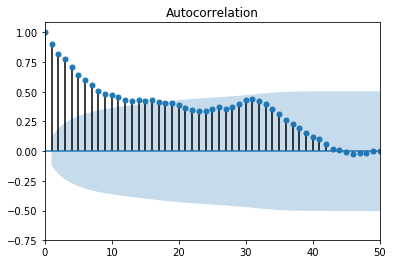

In [12]:
plot_acf(price_data.Price)
plt.xlim(0,50)
plt.show()

In [13]:
# This looks like a non-stationary time series so next we need 
# to transform the data to make it more stationary.

# We take a first difference of the data. This should help to 
# eliminate the overall trend from the data.

In [14]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 270 entries, 1997-01-31 to 2019-06-30
Freq: M
Data columns (total 1 columns):
Price    270 non-null float64
dtypes: float64(1)
memory usage: 4.2 KB


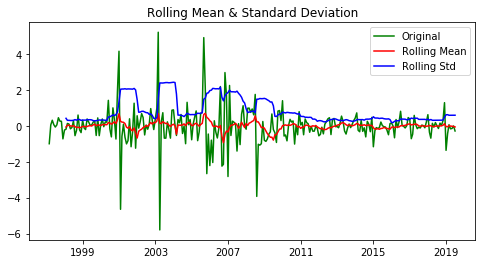

Results of Dickey-Fuller Test:
Test Statistic                -1.441891e+01
p-value                        7.972765e-27
#Lags Used                     1.000000e+00
Number of Observations Used    2.670000e+02
Critical Value (1%)           -3.455081e+00
Critical Value (5%)           -2.872427e+00
Critical Value (10%)          -2.572571e+00
dtype: float64


In [15]:
price_data['first_difference'] = price_data.Price - price_data.Price.shift(1)  
test_stationarity(price_data.first_difference.dropna(inplace=False))

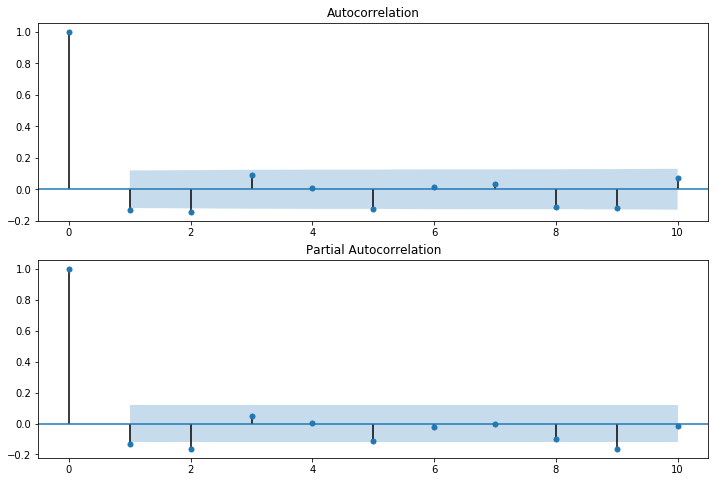

In [16]:
#Our data now looks more stationary

# Next we need to determine the tuning parameters of the model by looking
# at the autocorrelation and partial autocorrelation graphs. 
# We need to select the appropriate AR, MA, SAR, and MAR terms for the 
# model.

#Below are the ACF and PACF charts for the seasonal first difference 
# values (taking the data from the 13th instance onwards).

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(price_data.first_difference.iloc[1:], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(price_data.first_difference.iloc[1:], lags=10, ax=ax2)

In [17]:
resDiff = sm.tsa.arma_order_select_ic(price_data.Price, max_ar=7, max_ma=7, ic='aic', trend='c')
#resDiff = sm.tsa.arma_order_select_ic(price_data.first_difference.iloc[1:], max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

C:\Users\Christoph\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Christoph\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Christoph\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Christoph\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Christoph\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Convergen

ARMA(p,q) = (7, 3) is the best.


C:\Users\Christoph\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [18]:
# drop column
price_data = price_data.drop('first_difference', 1)

In [19]:
#Find the parameters for the SARIMA model via Grid Search

In [20]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], frequency) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [21]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(price_data.Price,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:1616.9618386779593
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1381.7320333409957
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1186.5442262533393
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1082.1987109591291
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1177.0646969470145
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1124.9864187528522
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1093.5251754320207
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1082.9827741568768
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1320.0459044911254
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:1147.06638613058
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:1015.38760397787
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:909.2091654262636
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1001.8758740402959
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:944.1496525170301
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:926.7420247351481
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:911.6264317808077
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:769.800611266663
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:744.4457596122314
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:948.

In [22]:
train = price_data[:200].dropna()
test = price_data[270:].dropna()

In [23]:
train.head()

,Price
Date,
1997-01-31,2.77
1997-02-28,1.78
1997-03-31,1.84
1997-04-30,2.16
1997-05-31,2.23


In [24]:
# Build Model

#Grid Search : ARIMA(0, 1, 0)x(0, 0, 1, 52) - AIC:1489.750308186387

mod = sm.tsa.statespace.SARIMAX(price_data.Price, trend='n', order=(0,1,0), seasonal_order=(0,0,1,12))
#mod = sm.tsa.statespace.SARIMAX(price_data.Price, trend='n', order=(1,1,1), seasonal_order=(0,0,1,52))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Price   No. Observations:                  270
Model:             SARIMAX(0, 1, 0)x(0, 0, 1, 12)   Log Likelihood                -383.409
Date:                            Sun, 11 Aug 2019   AIC                            770.818
Time:                                    12:41:06   BIC                            778.008
Sample:                                01-31-1997   HQIC                           773.706
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1301      0.055     -2.375      0.018      -0.238      -0.023
sigma2         1.0120      0.036   

In [25]:
#results = mod.fit()

In [26]:
pred = results.predict(start=200,end=300)[1:]

In [27]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 270 entries, 1997-01-31 to 2019-06-30
Freq: M
Data columns (total 1 columns):
Price    270 non-null float64
dtypes: float64(1)
memory usage: 14.2 KB


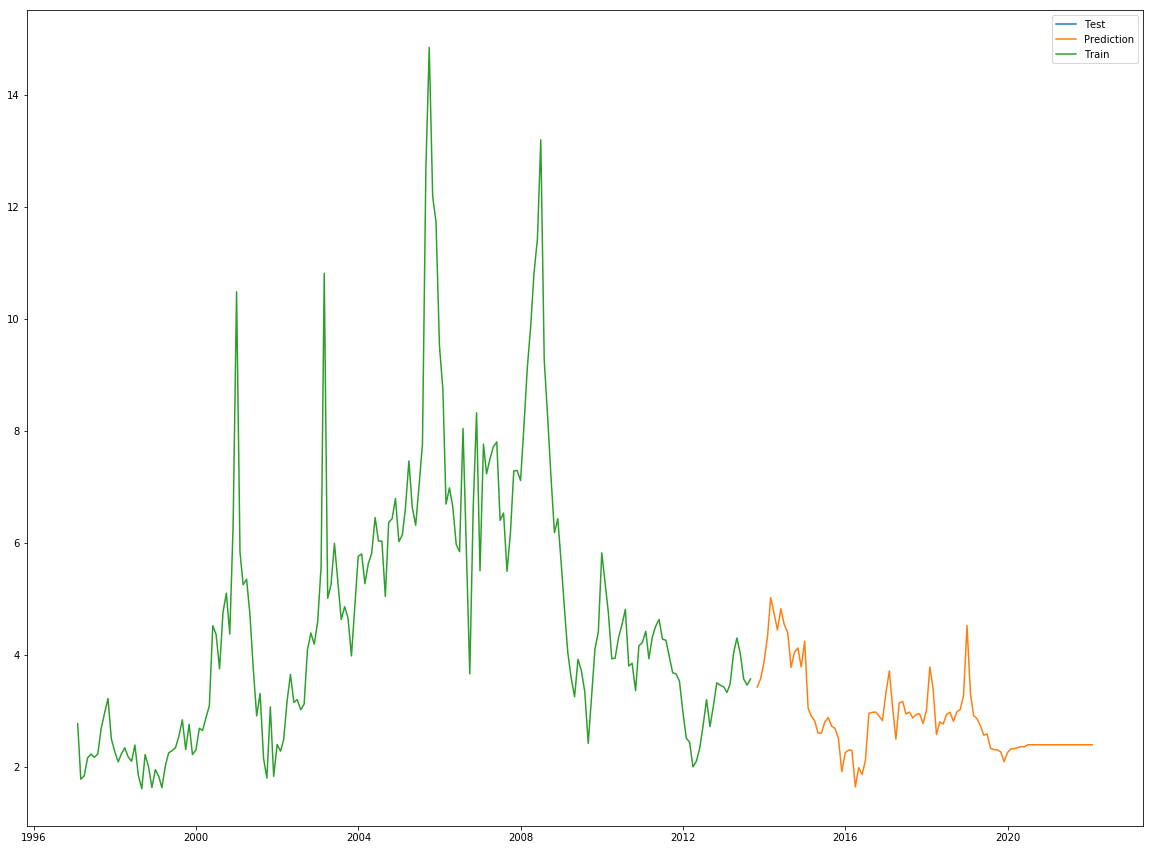

In [28]:
plt.figure(figsize=(20,15))
plt.plot(test,label='Test')
plt.plot(pred,label='Prediction')
plt.plot(train,label='Train')
plt.legend(loc='best')
plt.show()

In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  270
Model:             SARIMAX(0, 1, 0)x(0, 0, 1, 12)   Log Likelihood                -383.409
Date:                            Sun, 11 Aug 2019   AIC                            770.818
Time:                                    12:41:07   BIC                            778.008
Sample:                                01-31-1997   HQIC                           773.706
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1301      0.055     -2.375      0.018      -0.238      -0.023
sigma2         1.0120      0.036     28.240      0.000       0.942       1.082
===================================================================================
Ljung-Box (Q):                       85.30   Jarque-Bera (JB):              1267.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Freq: M
Data columns (total 1 columns):
Price    0 non-null float64
dtypes: float64(1)
memory usage: 0.0 bytes


In [31]:
#test_out = test[300:].dropna()

In [32]:
#train_out = train[300:].dropna()

In [33]:
#pred_out = pred[300:].dropna()

In [34]:
pred

2013-10-31    3.426544
2013-11-30    3.575548
2013-12-31    3.882715
2014-01-31    4.330719
2014-02-28    5.022911
2014-03-31    4.735268
2014-04-30    4.442755
2014-05-31    4.821975
2014-06-30    4.542496
2014-07-31    4.396521
2014-08-31    3.774783
2014-09-30    4.046214
2014-10-31    4.121331
2014-11-30    3.781681
2014-12-31    4.244394
2015-01-31    3.047696
2015-02-28    2.909009
2015-03-31    2.823220
2015-04-30    2.604810
2015-05-31    2.603203
2015-06-30    2.799845
2015-07-31    2.880233
2015-08-31    2.725485
2015-09-30    2.687795
2015-10-31    2.509215
2015-11-30    1.912547
2015-12-31    2.253723
2016-01-31    2.301824
2016-02-29    2.295488
2016-03-31    1.642542
                ...   
2019-08-31    2.308433
2019-09-30    2.304495
2019-10-31    2.267277
2019-11-30    2.093280
2019-12-31    2.258730
2020-01-31    2.322188
2020-02-29    2.325803
2020-03-31    2.342687
2020-04-30    2.361796
2020-05-31    2.358836
2020-06-30    2.394855
2020-07-31    2.394855
2020-08-31 

In [35]:
test

,Price
Date,


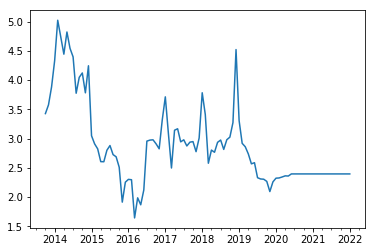

In [36]:
pred.plot()